In [1]:
from CollectMaPSAs import *
import pickle
import matplotlib.pyplot as plt
from mpa_configurations import *
from scipy.optimize import curve_fit
from scipy.special import erfc
from scipy.special import erf
from scipy.stats import chisquare

from contextlib import suppress

In [2]:
def errorf(x, *p):
    a, mu, sigma = p
    return 0.5*a*(1.0+erf((x-mu)/sigma))

def errorfc(x, *p):
    a, mu, sigma = p
    return a*0.5*erfc((x-mu)/sigma)

In [3]:
mapsa_names = ["HPK_35494_032L"]

In [4]:
plt.rc('font', size=22, weight='bold')
plt.rc('axes', titlesize=22)#, labelsize=18)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=22)
plt.rc('figure', titlesize=22)

In [5]:
mapsas = []
for m in mapsa_names:
    # Read MaPSA object from file, if available
    fname = 'pickles/'+m+'.pkl'
    if os.path.isfile(fname):
        print("Loading MaPSA " + m)
        mapsa = pickle.load(open(fname,'rb'))
    else: # Create it
        print("MaPSA " + m +" has no pickle")

    mapsas += [mapsa]

Loading MaPSA HPK_35494_032L


In [6]:
def extract_scurve(row, pixel, s_type, scurve, n_pulse, nominal_DAC, start, stop, extract = 1):                                                                                                                                                       
    th_array = np.zeros(conf.npixsnom, dtype = np.int )
    noise_array = np.zeros(conf.npixsnom, dtype = np.float )
    
    nfail = 0
    
    for r in row:
        for p in pixel:
            pixelid = conf.pixelidnom(r,p)

            # Noise and Spread study                                                                                                                                      
            if extract:
                
                try:
                
                    if s_type == "THR":
                        noise_peak = np.argmax(scurve[pixelid,:])
                        start_DAC = noise_peak + np.where(scurve[pixelid,noise_peak:] <= n_pulse)[0][0]
                        middle = noise_peak + np.argmin(np.abs(scurve[pixelid,noise_peak:]-0.5*n_pulse))
                        par, cov, info, mesg, ier = curve_fit(errorfc, list(range(start_DAC, stop - start_DAC)), scurve[pixelid,start_DAC + 1 :(stop-start_DAC) + 1], p0= [n_pulse, middle, 2], full_output = True, method='lm')
                        
                    elif s_type == "CAL":
                        start_DAC = start
                        middle = np.argmin(np.abs(scurve[pixelid,:]-0.5*n_pulse))
                        par, cov, info, mesg, ier = curve_fit(errorf, list(range(start_DAC, stop - start_DAC)), scurve[pixelid,start_DAC + 1 :(stop-start) + 1], p0= [n_pulse, middle, 2], full_output=True, method='lm')
                
                    th_array[pixelid] = int(round(par[1]))
                    noise_array[pixelid] = par[2]
                
                except RuntimeError as e:
                    nfail += 1

                    print(noise_peak, start_DAC, middle)
                    
                    th_array[pixelid] = -1
                    noise_array[pixelid] = -1
                    plt.plot(scurve[pixelid,:])
                    plt.show()
              
    print(nfail)
    
    if extract:
        return th_array, noise_array

In [7]:
s = np.array(mapsa.mpa_chips[0].THRS)
thr, noise = extract_scurve(row=conf.rowsnom, pixel=conf.colsnom, s_type = "THR", scurve = s, n_pulse=1000, start = 0, stop = 256, nominal_DAC = 0, extract = 1)

0


(array([1.000e+00, 0.000e+00, 4.000e+00, 7.000e+00, 2.900e+01, 1.734e+03,
        1.110e+02, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([ 52. ,  60.3,  68.6,  76.9,  85.2,  93.5, 101.8, 110.1, 118.4,
        126.7, 135. ]),
 <BarContainer object of 10 artists>)

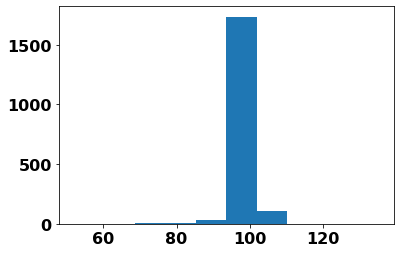

In [8]:
plt.hist(thr)

(array([  1.,  16., 294., 807., 569., 144.,  36.,   9.,   8.,   4.]),
 array([2.12608761, 2.33275957, 2.53943153, 2.74610349, 2.95277545,
        3.15944741, 3.36611937, 3.57279132, 3.77946328, 3.98613524,
        4.1928072 ]),
 <BarContainer object of 10 artists>)

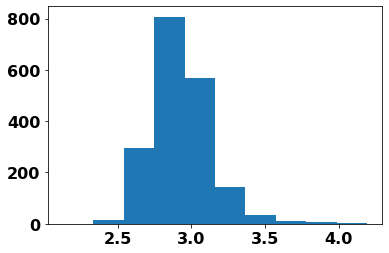

In [9]:
plt.hist(noise)

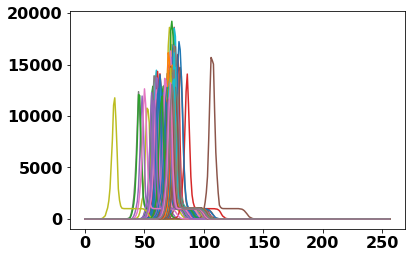

In [10]:
plt.plot(s.transpose());

In [11]:
pixelid=12
n_pulse=1000
stop=256
scurve = s
noise_peak = np.argmax(scurve[pixelid,:])
start_DAC = noise_peak + np.where(scurve[pixelid,noise_peak:] <= n_pulse)[0][0]
middle = noise_peak + np.argmin(np.abs(scurve[pixelid,noise_peak:]-0.5*n_pulse))
par, cov, info, mesg, ier = curve_fit(errorfc, list(range(start_DAC, stop - start_DAC)), scurve[pixelid,start_DAC + 1 :(stop-start_DAC) + 1], p0= [n_pulse, middle, 2], full_output = True, method='lm')


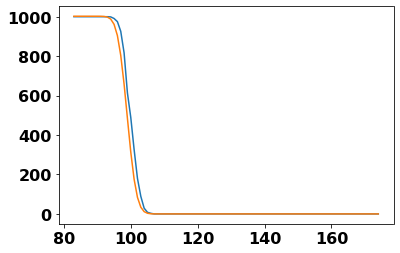

In [12]:
plt.plot(list(range(start_DAC+1, stop-start_DAC+1)),scurve[pixelid,start_DAC+1:stop-start_DAC+1]);
plt.plot(list(range(start_DAC+1, stop-start_DAC+1)),errorfc(list(range(start_DAC+1, stop-start_DAC+1)),*par));

In [13]:
observed = np.clip(scurve[pixelid,start_DAC+1:(stop-start_DAC)+1],1e-9,1000)
fitted = np.clip(errorfc(list(range(start_DAC+1,stop-start_DAC+1)),*par),1e-9,1000)
expected = np.sum(observed)/np.sum(fitted) * fitted

In [14]:
c, p = chisquare(scurve[pixelid,start_DAC+1:(stop-start_DAC)+1], expected, ddof=len(par))
print(c,p)

470.9842365848342 1.0665371547907996e-53


In [15]:
np.clip(errorfc(list(range(start_DAC+1, stop-start_DAC+1)),*par),1e-6,1000,)

array([1.00000000e+03, 1.00000000e+03, 1.00000000e+03, 1.00000000e+03,
       1.00000000e+03, 1.00000000e+03, 1.00000000e+03, 1.00000000e+03,
       1.00000000e+03, 1.00000000e+03, 9.98107646e+02, 9.87939964e+02,
       9.61403675e+02, 9.04456183e+02, 8.03960870e+02, 6.58123286e+02,
       4.84080511e+02, 3.13271643e+02, 1.75413580e+02, 8.39148152e+01,
       3.39748612e+01, 1.15611255e+01, 3.28947796e+00, 7.79583935e-01,
       1.53439977e-01, 2.50252908e-02, 3.37618051e-03, 3.76252159e-04,
       3.45987310e-05, 2.62289893e-06, 1.00000000e-06, 1.00000000e-06,
       1.00000000e-06, 1.00000000e-06, 1.00000000e-06, 1.00000000e-06,
       1.00000000e-06, 1.00000000e-06, 1.00000000e-06, 1.00000000e-06,
       1.00000000e-06, 1.00000000e-06, 1.00000000e-06, 1.00000000e-06,
       1.00000000e-06, 1.00000000e-06, 1.00000000e-06, 1.00000000e-06,
       1.00000000e-06, 1.00000000e-06, 1.00000000e-06, 1.00000000e-06,
       1.00000000e-06, 1.00000000e-06, 1.00000000e-06, 1.00000000e-06,
      